In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import random
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from scipy import zeros as sci_zeros
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

%matplotlib inline

## Monster

In [2]:
# data
job_info_data = pd.DataFrame()

base_URL = 'https://www.monster.ca/jobs/search/?q=data&jobid='

pages = list(range(0,100))
for page in pages:
    newpage="https://www.monster.ca/jobs/search/?q=data&stpage=1&page="+str(page)
    result = requests.get(newpage).text
    soup = BeautifulSoup(result, 'lxml')
    for jobs in soup.find_all('section', class_='card-content'): 
        try:
            position_title = jobs.find('h2', class_='title').text.strip()
        except:
            position_title = None
        try:
            employer = jobs.find('div', class_='company').text.strip()
        except:
            employer = None
        try:
            location = jobs.find('div', class_='location').text.strip()
        except:
            location = None
        try:
            salary=div.find('nobr').text
        except:
            try:
                div_two = div.find(name='div', attrs={'class':'sjcl'})
                div_three = div_two.find('div')
                salary=div_three.text.strip()
            except:
                salary = None
        try:
            link = jobs.find('a')['href']
        except:
            link = None
        job_info_data = job_info_data.append({
            'position_title': position_title, 
            'employer': employer,
            'location': location,
            'salary': salary,
            'link': link}, ignore_index = True)

#Delect duplicate jobs
job_info_data = job_info_data.drop_duplicates(['link'], keep='first')
job_info_data.head(10)

,employer,link,location,position_title,salary
0,None,None,None,None,None
1,050 Best Buy Canada Ltd.,https://job-openings.monster.ca/cloud-data-eng...,,Cloud Data Engineer,None
3,EU Health and Innovations Inc,https://job-openings.monster.ca/systems-consul...,"Thornhill, ON",Systems Consultant & Data Analyst,None
4,Luxoft USA Inc,https://job-openings.monster.ca/aws-data-lake-...,"Calgary, AB",AWS Data Lake Migration Specialist,None
5,Geomodeling,https://job-openings.monster.ca/data-scientist...,"Calgary, AB",DATA SCIENTIST NOC 2172,None
6,VTRAC Consulting Corporation,https://job-openings.monster.ca/senior-data-en...,"TORONTO, ON","Senior Data Engineer - Azure, Python, Kafka (C...",None
7,Morgan Stanley,https://job-openings.monster.ca/bi-data-analys...,"Montreal, QC",BI/Data Analyst 3155721,None
9,Robertson & Company Ltd.,https://job-openings.monster.ca/enterprise-ful...,"TORONTO, ON",Enterprise Full Stack Engineer – Big Data (perm),None
10,Prodigy Bank,https://job-openings.monster.ca/data-scientist...,"Toronto, ON",Data Scientist,None
11,Juventus Consulting,https://job-openings.monster.ca/data-analyst-m...,"Markham, ON",Data Analyst,None


In [3]:
job_info_data.shape

(1857, 5)

In [4]:
# List possible skill requirements
technical_skill = ['excel', 'python', 'r', 'java', 'c', 'c++', 'matlab', 'sas','sql', 
                   'tableau', 'hadoop', 'spark','power bi',
                   'tensorflow', 'keras','pytorch','theano','caffe']
business_skill = ['communication', 'problem solving', 'project management', 'consulting', 
                  'presentation', 'leadership', 'documentation', 'marketing','lead', 
                  'time management', 'collaborate', 'organize']
skills = technical_skill + business_skill 
# Add columns for skills
for skill in skills:
  job_info_data[skill] = np.zeros(len(job_info_data))


job_info_data.head()

,employer,link,location,position_title,salary,excel,python,r,java,c,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,050 Best Buy Canada Ltd.,https://job-openings.monster.ca/cloud-data-eng...,,Cloud Data Engineer,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EU Health and Innovations Inc,https://job-openings.monster.ca/systems-consul...,"Thornhill, ON",Systems Consultant & Data Analyst,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Luxoft USA Inc,https://job-openings.monster.ca/aws-data-lake-...,"Calgary, AB",AWS Data Lake Migration Specialist,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Geomodeling,https://job-openings.monster.ca/data-scientist...,"Calgary, AB",DATA SCIENTIST NOC 2172,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
job_info_data = job_info_data.drop([0])
job_info_data = job_info_data.reset_index()
job_info_data = job_info_data.drop(["index"],axis=1)
job_info_data.head()

,employer,link,location,position_title,salary,excel,python,r,java,c,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,050 Best Buy Canada Ltd.,https://job-openings.monster.ca/cloud-data-eng...,,Cloud Data Engineer,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EU Health and Innovations Inc,https://job-openings.monster.ca/systems-consul...,"Thornhill, ON",Systems Consultant & Data Analyst,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Luxoft USA Inc,https://job-openings.monster.ca/aws-data-lake-...,"Calgary, AB",AWS Data Lake Migration Specialist,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Geomodeling,https://job-openings.monster.ca/data-scientist...,"Calgary, AB",DATA SCIENTIST NOC 2172,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,VTRAC Consulting Corporation,https://job-openings.monster.ca/senior-data-en...,"TORONTO, ON","Senior Data Engineer - Azure, Python, Kafka (C...",None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# For each job, check its job details/description page
# to collect the required skills.
# Set skill entries to 1 if they are mentioned in job details
for i in range(len(job_info_data)):
  link = requests.get(job_info_data.iloc[i,1])
  soup = BeautifulSoup(link.text, "lxml")
  try:
    text = soup.find('div', class_='job-description').text.strip().lower()
    # Preprocessing, replace punctuations, and replace multiple spaces
    text = re.sub(r'\,', ' ', text) 
    text = re.sub('/', ' ', text) 
    text = re.sub(r'\(', ' ', text) 
    text = re.sub(r'\)', ' ', text) 
    text = re.sub(' +',' ',text) 
  except:
    text = "" 
  for s in skills :
    # This is specifically for C++, escape the ++. Convert C++ to C\+\+
    if any(x in s for x in ['+']):
      skill = re.escape(s)
    else:
      skill = s
    # print("check skill ",s, "for job ",str(i+1))
    matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
    if matching:
      # print("matched skill ",s, "for job ",str(i+1))
      job_info_data[s][i] = 1


C:\Users\dell\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
job_info_data

,employer,link,location,position_title,salary,excel,python,r,java,c,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,050 Best Buy Canada Ltd.,https://job-openings.monster.ca/cloud-data-eng...,,Cloud Data Engineer,None,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,EU Health and Innovations Inc,https://job-openings.monster.ca/systems-consul...,"Thornhill, ON",Systems Consultant & Data Analyst,None,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,Luxoft USA Inc,https://job-openings.monster.ca/aws-data-lake-...,"Calgary, AB",AWS Data Lake Migration Specialist,None,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Geomodeling,https://job-openings.monster.ca/data-scientist...,"Calgary, AB",DATA SCIENTIST NOC 2172,None,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,VTRAC Consulting Corporation,https://job-openings.monster.ca/senior-data-en...,"TORONTO, ON","Senior Data Engineer - Azure, Python, Kafka (C...",None,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,Ferrovial Services,https://job-openings.monster.ca/seasonal-equip...,"Sault Ste. Marie, ON","Seasonal Equipment Operator - Thessalon, Goula...",None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1852,Calgary Co-operative Association Limited,https://job-openings.monster.ca/deli-manager-c...,"Calgary, AB",Deli Manager,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1853,Ontario college of traditional Chinese medicine,https://job-openings.monster.ca/health-promoti...,"Markham, ON",Health Promotion Program Officer,None,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1854,Drakkar,https://job-openings.monster.ca/full-time-perm...,"Thunder Bay, ON",Full-time permanent AZ Driver,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Sanity check
job_info_data['excel'].sum()

339.0

In [9]:
# Save to local
job_info_data.to_csv("C:/Users/dell/Desktop/MIE 1624/Project/Web Scraping/monster_data.csv")

In [10]:
import matplotlib.pyplot as plt
df_tech = job_info_data[technical_skill]
tech_count = df_tech.sum()
tech_count = tech_count.sort_values(ascending=False)
df_tcount = pd.DataFrame(data=tech_count,columns=["Count"])
df_tcount.index.name = "Technical Skills"
df_tcount
#plt.bar(,tech_count.to_list)

,Count
Technical Skills,
sql,341.0
excel,339.0
python,200.0
java,177.0
power bi,71.0
c,58.0
spark,57.0
r,56.0
c++,52.0


Text(0.5, 1.0, 'Technical Skills Demand for Data Science Jobs on Monster')

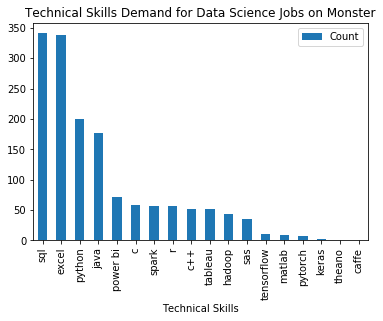

In [11]:
df_tcount.plot(kind="bar")
plt.title('Technical Skills Demand for Data Science Jobs on Monster')

In [12]:
df_bus = job_info_data[business_skill]
bus_count = df_bus.sum()
bus_count = bus_count.sort_values(ascending=False)
df_bcount = pd.DataFrame(data=bus_count,columns=["Count"])
df_bcount.index.name = "Business Skills"
df_bcount
#plt.bar(,tech_count.to_list)

,Count
Business Skills,
communication,876.0
lead,397.0
documentation,324.0
leadership,312.0
problem solving,201.0
marketing,177.0
project management,152.0
presentation,142.0
consulting,131.0


Text(0.5, 1.0, 'Business Skills Demand for Data Science Jobs on Monster')

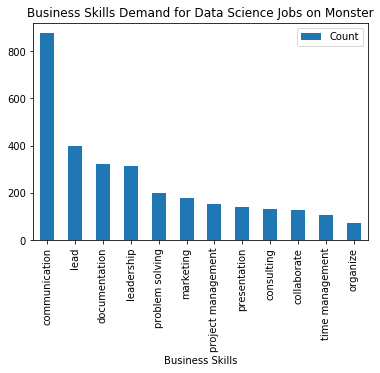

In [13]:
df_bcount.plot(kind="bar")
plt.title('Business Skills Demand for Data Science Jobs on Monster')

In [14]:
# AI
job_info_ai = pd.DataFrame()

base_URL = 'https://www.monster.ca/jobs/l-toronto-on'


pages = list(range(0,32))
for page in pages:
    
    newpage="https://www.monster.ca/jobs/search/?q=Artificial-Intelligence&stpage=1&page="+str(page)
    result = requests.get(newpage).text
    soup = BeautifulSoup(result, 'lxml')
    for jobs in soup.find_all('section', class_='card-content'): 
        try:
            position_title = jobs.find('h2', class_='title').text.strip()
        except:
            position_title = None
        try:
            employer = jobs.find('div', class_='company').text.strip()
        except:
            employer = None
        try:
            location = jobs.find('div', class_='location').text.strip()
        except:
            location = None
        try:
            salary=div.find('nobr').text
        except:
            try:
                div_two = div.find(name='div', attrs={'class':'sjcl'})
                div_three = div_two.find('div')
                salary=div_three.text.strip()
            except:
                salary = None
        try:
            link = jobs.find('a')['href']
        except:
            link = None
        job_info_ai = job_info_ai.append({
            'position_title': position_title, 
            'employer': employer,
            'location': location,
            'salary': salary,
            'link': link}, ignore_index = True)

#Delect duplicate jobs
job_info_ai = job_info_ai.drop_duplicates(['link'], keep='first')


In [15]:
job_info_ai

,employer,link,location,position_title,salary
0,None,None,None,None,None
1,SAPSOL TECHNOLOIGES INC,https://job-openings.monster.ca/freshers-in-ar...,"Mississauga, ON","Freshers in Artificial Intelligence, Machine l...",None
3,Magna International Inc.,https://job-openings.monster.ca/robotics-weld-...,"Milton, ON",Robotics Weld Technician,None
4,Kutir Technologies,https://job-openings.monster.ca/machine-learni...,"Mississauga, ON",Machine Learning (Computer Vision),None
5,ADGA Group,https://job-openings.monster.ca/cognos-etl-pro...,"Toronto, ON",Cognos/ETL Programmer/Developer,None
...,...,...,...,...,...
2150,Digital Shift,https://job-openings.monster.ca/link-prospecto...,"Calgary, AB",Link Prospector & Outreach Specialist,None
2151,NCR,https://job-openings.monster.ca/technical-writ...,WATERLOO,"Technical Writer - Waterloo, CAN",None
2152,Pomeroy Lodging LP,https://job-openings.monster.ca/part-time-nigh...,"Olds, AB",Part Time Night auditor and Front desk agent,None
2153,Pro Mach Integrated Solutions Canada Inc,https://job-openings.monster.ca/electrical-pro...,"Oakville, ON",Electrical Project Engineer,None


In [16]:
# List possible skill requirements
technical_skill = ['excel', 'python', 'r', 'java', 'c', 'c++', 'matlab', 'sas','sql', 
                   'tableau', 'hadoop', 'spark','power bi',
                   'tensorflow', 'keras','pytorch','theano','caffe']
business_skill = ['communication', 'problem solving', 'project management', 'consulting', 
                  'presentation', 'leadership', 'documentation', 'marketing','lead', 
                  'time management', 'collaborate', 'organize']
skills = technical_skill + business_skill 
# Add columns for skills
for skill in skills:
  job_info_ai[skill] = np.zeros(len(job_info_ai))


job_info_ai.head()

,employer,link,location,position_title,salary,excel,python,r,java,c,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SAPSOL TECHNOLOIGES INC,https://job-openings.monster.ca/freshers-in-ar...,"Mississauga, ON","Freshers in Artificial Intelligence, Machine l...",None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Magna International Inc.,https://job-openings.monster.ca/robotics-weld-...,"Milton, ON",Robotics Weld Technician,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Kutir Technologies,https://job-openings.monster.ca/machine-learni...,"Mississauga, ON",Machine Learning (Computer Vision),None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ADGA Group,https://job-openings.monster.ca/cognos-etl-pro...,"Toronto, ON",Cognos/ETL Programmer/Developer,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
job_info_ai = job_info_ai.drop([0])
job_info_ai = job_info_ai.reset_index()
job_info_ai = job_info_ai.drop(["index"],axis=1)
job_info_ai.head()

,employer,link,location,position_title,salary,excel,python,r,java,c,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,SAPSOL TECHNOLOIGES INC,https://job-openings.monster.ca/freshers-in-ar...,"Mississauga, ON","Freshers in Artificial Intelligence, Machine l...",None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Magna International Inc.,https://job-openings.monster.ca/robotics-weld-...,"Milton, ON",Robotics Weld Technician,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Kutir Technologies,https://job-openings.monster.ca/machine-learni...,"Mississauga, ON",Machine Learning (Computer Vision),None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ADGA Group,https://job-openings.monster.ca/cognos-etl-pro...,"Toronto, ON",Cognos/ETL Programmer/Developer,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Modis, Inc.",https://job-openings.monster.ca/data-architect...,"Toronto, ON",Data Architect/Modeller,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# For each job, check its job details/description page
# to collect the required skills.
# Set skill entries to 1 if they are mentioned in job details
for i in range(len(job_info_ai)):
  link = requests.get(job_info_ai.iloc[i,1])
  soup = BeautifulSoup(link.text, "lxml")
  try:
    text = soup.find('div', class_='job-description').text.strip().lower()
    # Preprocessing, replace punctuations, and replace multiple spaces
    text = re.sub(r'\,', ' ', text) 
    text = re.sub('/', ' ', text) 
    text = re.sub(r'\(', ' ', text) 
    text = re.sub(r'\)', ' ', text) 
    text = re.sub(' +',' ',text) 
  except:
    text = "" 
  for s in skills :
    # This is specifically for C++, escape the ++. Convert C++ to C\+\+
    if any(x in s for x in ['+']):
      skill = re.escape(s)
    else:
      skill = s
    # print("check skill ",s, "for job ",str(i+1))
    matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
    if matching:
      # print("matched skill ",s, "for job ",str(i+1))
      job_info_ai[s][i] = 1


C:\Users\dell\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
job_info_ai

,employer,link,location,position_title,salary,excel,python,r,java,c,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,SAPSOL TECHNOLOIGES INC,https://job-openings.monster.ca/freshers-in-ar...,"Mississauga, ON","Freshers in Artificial Intelligence, Machine l...",None,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Magna International Inc.,https://job-openings.monster.ca/robotics-weld-...,"Milton, ON",Robotics Weld Technician,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Kutir Technologies,https://job-openings.monster.ca/machine-learni...,"Mississauga, ON",Machine Learning (Computer Vision),None,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ADGA Group,https://job-openings.monster.ca/cognos-etl-pro...,"Toronto, ON",Cognos/ETL Programmer/Developer,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Modis, Inc.",https://job-openings.monster.ca/data-architect...,"Toronto, ON",Data Architect/Modeller,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,Digital Shift,https://job-openings.monster.ca/link-prospecto...,"Calgary, AB",Link Prospector & Outreach Specialist,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
709,NCR,https://job-openings.monster.ca/technical-writ...,WATERLOO,"Technical Writer - Waterloo, CAN",None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
710,Pomeroy Lodging LP,https://job-openings.monster.ca/part-time-nigh...,"Olds, AB",Part Time Night auditor and Front desk agent,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711,Pro Mach Integrated Solutions Canada Inc,https://job-openings.monster.ca/electrical-pro...,"Oakville, ON",Electrical Project Engineer,None,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Save to local
job_info_ai.to_csv("C:/Users/dell/Desktop/MIE 1624/Project/Web Scraping/monster_ai.csv")

In [21]:
import matplotlib.pyplot as plt
df_tech = job_info_ai[technical_skill]
tech_count = df_tech.sum()
tech_count = tech_count.sort_values(ascending=False)
df_tcount = pd.DataFrame(data=tech_count,columns=["Count"])
df_tcount.index.name = "Technical Skills"
df_tcount
#plt.bar(,tech_count.to_list)

,Count
Technical Skills,
sql,178.0
python,162.0
java,106.0
excel,89.0
c++,68.0
c,56.0
spark,48.0
r,45.0
hadoop,40.0


Text(0.5, 1.0, 'Technical Skills Demand for Data Science Jobs on Monster')

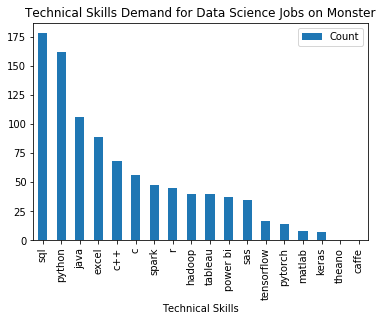

In [22]:
df_tcount.plot(kind="bar")
plt.title('Technical Skills Demand for Data Science Jobs on Monster')

In [23]:
df_bus = job_info_ai[business_skill]
bus_count = df_bus.sum()
bus_count = bus_count.sort_values(ascending=False)
df_bcount = pd.DataFrame(data=bus_count,columns=["Count"])
df_bcount.index.name = "Business Skills"
df_bcount
#plt.bar(,tech_count.to_list)

,Count
Business Skills,
communication,358.0
lead,208.0
leadership,170.0
documentation,136.0
collaborate,128.0
consulting,99.0
problem solving,79.0
marketing,63.0
presentation,50.0


Text(0.5, 1.0, 'Business Skills Demand for Data Science Jobs on Monster')

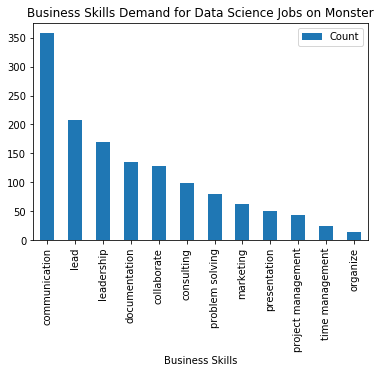

In [24]:
df_bcount.plot(kind="bar")
plt.title('Business Skills Demand for Data Science Jobs on Monster')

In [25]:
df = pd.read_csv('monster_ai.csv')
df.head(10)

,Unnamed: 0,employer,link,location,position_title,salary,excel,python,r,java,...,project management,consulting,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize
0,0,SAPSOL TECHNOLOIGES INC,https://job-openings.monster.ca/freshers-in-ar...,"Mississauga, ON","Freshers in Artificial Intelligence, Machine l...",NaN,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Magna International Inc.,https://job-openings.monster.ca/robotics-weld-...,"Milton, ON",Robotics Weld Technician,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Kutir Technologies,https://job-openings.monster.ca/machine-learni...,"Mississauga, ON",Machine Learning (Computer Vision),NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,ADGA Group,https://job-openings.monster.ca/cognos-etl-pro...,"Toronto, ON",Cognos/ETL Programmer/Developer,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,"Modis, Inc.",https://job-openings.monster.ca/data-architect...,"Toronto, ON",Data Architect/Modeller,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,5,IBM CA,https://job-openings.monster.ca/data-modeller-...,"Toronto, ON",Data Modeller /SQL Developer,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,ISG Search Inc,https://job-openings.monster.ca/senior-manager...,"Toronto, ON","Senior Manager, Data Analytics (Retail/Mining)",NaN,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,Procom,https://job-openings.monster.ca/data-architect...,"Edmonton, AB",Data Architect,NaN,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,8,Hays,https://job-openings.monster.ca/lead-machine-l...,"Vancouver, BC",Lead Machine Learning Engineer,NaN,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,9,Randstad,https://job-openings.monster.ca/cloud-data-arc...,"Toronto, ON",Cloud Data Architect,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df.drop(['Unnamed: 0','employer', 'link', 'position_title','salary','location'],axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   excel               713 non-null    float64
 1   python              713 non-null    float64
 2   r                   713 non-null    float64
 3   java                713 non-null    float64
 4   c                   713 non-null    float64
 5   c++                 713 non-null    float64
 6   matlab              713 non-null    float64
 7   sas                 713 non-null    float64
 8   sql                 713 non-null    float64
 9   tableau             713 non-null    float64
 10  hadoop              713 non-null    float64
 11  spark               713 non-null    float64
 12  power bi            713 non-null    float64
 13  tensorflow          713 non-null    float64
 14  keras               713 non-null    float64
 15  pytorch             713 non-null    float64
 16  theano  

In [27]:
# count the number of empty entries in each feature
NaNcount = [df[x].isna().sum() for x in list(df)]
print(NaNcount)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
df['programming_skill']=df.iloc[:,0:18].sum(axis=1)
df['business_skill']=df.iloc[:,19:31].sum(axis=1)
df

,excel,python,r,java,c,c++,matlab,sas,sql,tableau,...,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize,programming_skill,business_skill
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [29]:
df1 = normalize(df)
df1 = pd.DataFrame(df1, columns=df.columns)
df1.head()

,excel,python,r,java,c,c++,matlab,sas,sql,tableau,...,presentation,leadership,documentation,marketing,lead,time management,collaborate,organize,programming_skill,business_skill
0,0.0,0.147442,0.0,0.147442,0.147442,0.147442,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.589768,0.737210
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.000000,0.707107
2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.707107
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.000000,0.707107
